# Simulate experiment
We will simulate data from a deep mutational scanning experiment using the RBD antibody mix in order to provide hypothetical data on which to fit a `Polyclonal` model.

We first define a `Polyclonal` object that represents the antibody mix we want to simulate.
This mix is again based on the three RBD antibodies targeting class 1, 2, and 3 epitopes.

In [1]:
import pandas as pd

import polyclonal

# read data needed to initialize `Polyclonal` object
activity_wt_df = pd.read_csv("RBD_activity_wt_df.csv")
mut_escape_df = pd.read_csv("RBD_mut_escape_df.csv")

# create `Polyclonal` object with actual antibody mix
poly_abs = polyclonal.Polyclonal(
    activity_wt_df=activity_wt_df, mut_escape_df=mut_escape_df
)

print(f"Epitopes: {poly_abs.epitopes}")
print(f"Number of mutations: {len(poly_abs.mutations)}")
print(f"Number of sites: {len(poly_abs.sites)}")

Epitopes: ('class 1', 'class 2', 'class 3')
Number of mutations: 1932
Number of sites: 173


Now we simulate libraries of variants with an average of 1, 2, 3, or 4 mutations per gene.
These libraries only contain mutations for which we defined mutation escape above.
We a [dms_variants](https://jbloomlab.github.io/dms_variants/) `CodonVariantTable` for the RBD with these mutations.
Note that because the `CodonVariantTable` requires sequential 1, 2, ... numbering, we have to do some shifting of sites back and forth with an offset of 331 since that is where the RBD starts.

In [2]:
import Bio.SeqIO

import dms_variants.simulate

import polyclonal.utils

# read coding sequence, then slice to just region of interest
# noting that RBD starts at residue 331
geneseq = str(Bio.SeqIO.read("RBD_seq.fasta", "fasta").seq)

allowed_aa_muts = poly_abs.mut_escape_df["mutation"].unique()
print(f"There are {len(allowed_aa_muts)} allowed amino-acid mutations.")

variants = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq,
    bclen=16,
    library_specs={
        f"avg{m}muts": {"avgmuts": m, "nvariants": 30000} for m in [1, 2, 3, 4]
    },
    allowed_aa_muts=[polyclonal.utils.shift_mut_site(m, -330) for m in allowed_aa_muts],
)

There are 1932 allowed amino-acid mutations.


Now look at the distribution of the number of amino-acid mutations per-variant in the library.
The mutation rate is relatively high as we pre-screened for tolerated mutations and need multiple mutants to decompose the sera mix:

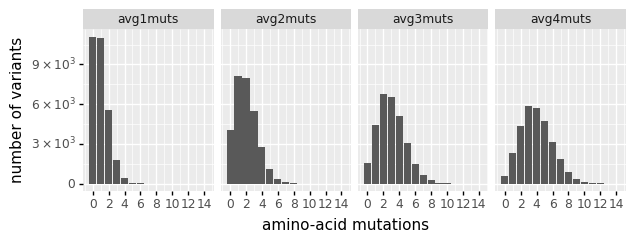

In [3]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotNumMutsHistogram(
    mut_type="aa", samples=None, libraries=variants.libraries
)
_ = p.draw()

We also look at the mutation rate across the gene.
Note that this is sequential numbering of the sequence.
Also, the per-site mutation frequency is uneven because we only include tolerated mutations, and there are different number of tolerated mutations per site:

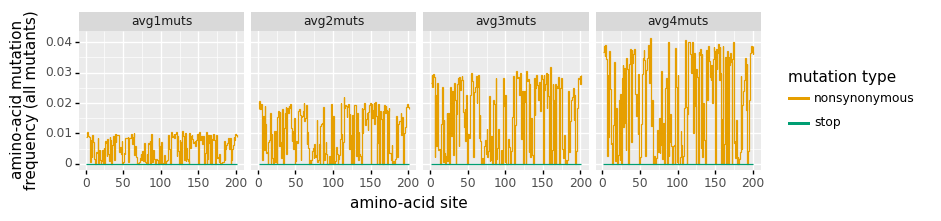

In [4]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotMutFreqs(
    variant_type="all", mut_type="aa", samples=None, libraries=variants.libraries
)
_ = p.draw()

Now we get the data frame with the amino-acid substitutions for each variant, re-adding site offset to get back to RBD numbering:

In [5]:
variants_df = variants.barcode_variant_df[
    ["library", "barcode", "aa_substitutions", "n_aa_substitutions"]
].assign(
    aa_substitutions=lambda x: x["aa_substitutions"].apply(
        polyclonal.utils.shift_mut_site, shift=330
    )
)

variants_df

,library,barcode,aa_substitutions,n_aa_substitutions
0,avg1muts,AAAAAAAATTTACGCG,F486P,1
1,avg1muts,AAAAAACTATGCACCT,Q498N,1
2,avg1muts,AAAAAAGACGCTGTGC,P337S,1
3,avg1muts,AAAAAATAGTTCTGAT,S371F R408V,2
4,avg1muts,AAAAACAGACCTACAA,A372M C391E G482N,3
...,...,...,...,...
119995,avg4muts,TTTTTTGATGCTATTA,S373L T385R D427L S469N N487S,5
119996,avg4muts,TTTTTTGGTTGCGCCT,T333Q A372S L455C K458S,4
119997,avg4muts,TTTTTTTCGATATCCT,V367L P384L N439Q G447A Y453K S459P,6
119998,avg4muts,TTTTTTTTACATCAGC,Q498L,1


Now we use our `Polyclonal` object to compute the predicted probability of escape ($p_v\left(c\right)$) at multiple serum concentrations given the mutation escape values $\beta_{m,e}$ and activities $a_{\rm{wt},e}$ stored in the `Polyclonal` object.
Since we will use these as the "true" values in our our simulation, we then rename the column with the predicted probabilities of escape to just be the probabilities of escape:

In [6]:
variants_escape = poly_abs.prob_escape(
    variants_df=variants_df, concentrations=[0.125, 0.25, 0.5, 1, 2, 4]
)

variants_escape = variants_escape.rename(
    columns={"predicted_prob_escape": "prob_escape"}
)

variants_escape

,library,barcode,aa_substitutions,n_aa_substitutions,concentration,prob_escape
0,avg1muts,AAAAACGCGGTCACTT,,0,0.125,0.085566
1,avg1muts,AAAAAGCACCATAACG,,0,0.125,0.085566
2,avg1muts,AAAAAGGGAGCTAAAC,,0,0.125,0.085566
3,avg1muts,AAAAAGTCGGATGGGC,,0,0.125,0.085566
4,avg1muts,AAAAAGTCTTAGGGAA,,0,0.125,0.085566
...,...,...,...,...,...,...
719995,avg2muts,CCGGGTACTAAAAAGG,Y508W,1,4.000,0.000161
719996,avg3muts,CCCTGCACCCCACATA,Y508W,1,4.000,0.000161
719997,avg4muts,GTGATTTAGCGTCTCG,Y508W,1,4.000,0.000161
719998,avg4muts,GGGAAATTAGACTTTC,Y508W C525F,2,4.000,0.000655


Plot some features of the variants, namely the distribution of probability of escape for each number of mutations.
As expected, variants with many mutations are more likely to escape the serum:

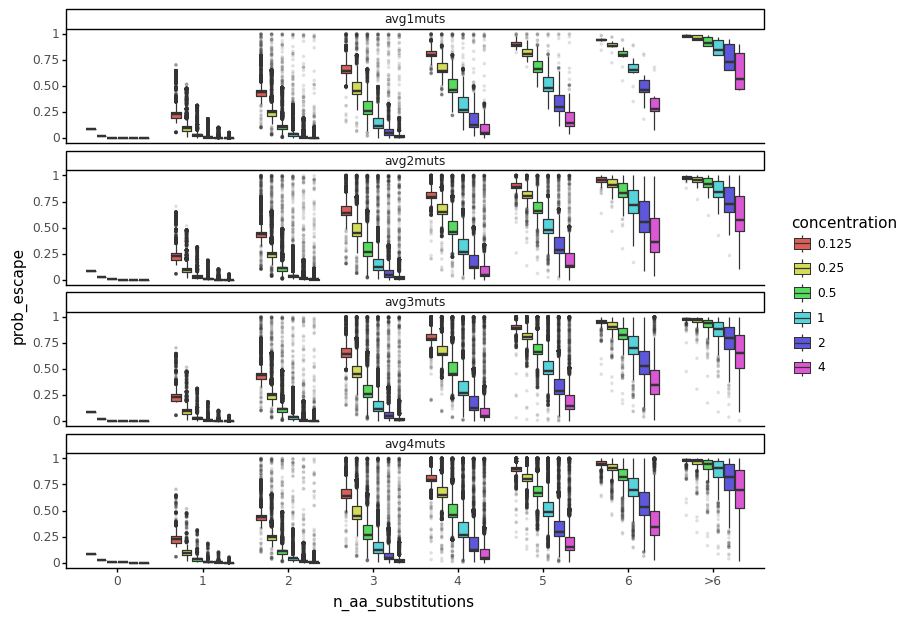

In [7]:
# NBVAL_IGNORE_OUTPUT

from plotnine import *

p = (
    ggplot(
        variants_escape.assign(
            n_aa_substitutions=lambda x: x["n_aa_substitutions"].map(
                lambda n: str(n) if n <= 6 else ">6"
            ),
            concentration=lambda x: pd.Categorical(x["concentration"]),
        )
    )
    + aes("n_aa_substitutions", "prob_escape", fill="concentration")
    + geom_boxplot(outlier_size=0.5, outlier_alpha=0.1)
    + facet_wrap("~ library", ncol=1)
    + theme_classic()
    + theme(figure_size=(9, 7))
)

_ = p.draw()

Also, just compute the overall average probability of escape for each library:

In [8]:
(
    variants_escape.groupby(["library", "concentration"]).aggregate(
        {"prob_escape": "mean"}
    )
)

prob_escape
library  concentration             
avg1muts 0.125             0.263789
         0.250             0.145056
         0.500             0.073018
         1.000             0.035075
         2.000             0.016744
         4.000             0.008258
avg2muts 0.125             0.446783
         0.250             0.305320
         0.500             0.193629
         1.000             0.116173
         2.000             0.067517
         4.000             0.039012
avg3muts 0.125             0.603217
         0.250             0.466845
         0.500             0.339147
         1.000             0.233266
         2.000             0.153923
         4.000             0.099108
avg4muts 0.125             0.725139
         0.250             0.609332
         0.500             0.486684
         1.000             0.370326
         2.000             0.270021
         4.000             0.190446

We also want to acknowledge the fact that a real experiment will have some noise in the data. This noise is likely to come in two forms:
  
  1. Inaccuracies in the measurements of the probabilities of escape, $p_v\left(c\right)$.
  2. Occassional mis-assignment of which mutations are in a variant due to sequencing errors.
  
We therefore will make a "noisy" version of `variants_df` where we have incorporated both of these sources of noise by adding Gaussian measurement error to the escape probabilities (but then truncating them to be between 0 and 1), and by adding or subtracting a mutation to occassional variants to represent sequencing errors.

In [9]:
import numpy

numpy.random.seed(1)  # seed for reproducible output


def add_subtract_mutation(subs):
    """Sometimes add or subtract a mutation."""
    subs = subs.split()
    sub_sites = [int(sub[1:-1]) for sub in subs]
    rand = numpy.random.random()
    if rand < 0.01:  # add mutation with 1% probability
        mut = numpy.random.choice(poly_abs.mutations)
        while int(mut[1:-1]) in sub_sites:
            mut = numpy.random.choice(poly_abs.mutations)
        subs.append(mut)
    elif rand > 0.99 and subs:  # subtract mutation with 1% probability
        subs.pop(numpy.random.randint(len(subs)))
    return " ".join(subs)


# only keep needed columns in variants_escape
variants_escape = variants_escape[
    ["library", "aa_substitutions", "concentration", "prob_escape"]
]

# simulate noisy variants
noisy_variants_escape = variants_escape.assign(
    # add Gaussian noise with standard deviation of 0.05
    prob_escape=lambda x: (
        x["prob_escape"] + numpy.random.normal(scale=0.05, size=len(x))
    ).clip(lower=0, upper=1),
    # add rare sequencing errors to variants
    aa_substitutions=lambda x: x["aa_substitutions"].map(add_subtract_mutation),
)

noisy_variants_escape

,library,aa_substitutions,concentration,prob_escape
0,avg1muts,,0.125,0.166783
1,avg1muts,,0.125,0.054978
2,avg1muts,,0.125,0.059157
3,avg1muts,,0.125,0.031918
4,avg1muts,,0.125,0.128836
...,...,...,...,...
719995,avg2muts,Y508W,4.000,0.046410
719996,avg3muts,Y508W,4.000,0.022680
719997,avg4muts,Y508W,4.000,0.030200
719998,avg4muts,Y508W C525F,4.000,0.036181


For both the exact and noisy data frames, we will also compute the IC90 for each variant based on the simulated antibody mix:

In [10]:
variants_escape = poly_abs.icXX(variants_escape, x=0.9, col="IC90")

noisy_variants_escape = poly_abs.icXX(noisy_variants_escape, x=0.9, col="IC90")

noisy_variants_escape

,library,aa_substitutions,concentration,prob_escape,IC90
0,avg1muts,,0.125,0.166783,0.112813
1,avg1muts,,0.125,0.054978,0.112813
2,avg1muts,,0.125,0.059157,0.112813
3,avg1muts,,0.125,0.031918,0.112813
4,avg1muts,,0.125,0.128836,0.112813
...,...,...,...,...,...
719995,avg2muts,Y473E L518F D427L,4.000,0.002918,1.159910
719996,avg1muts,Y473S G413Q,4.000,0.000000,0.577999
719997,avg1muts,Y473V P479R F392W,4.000,0.160248,1.454528
719998,avg3muts,Y489Q N501Y,4.000,0.000000,0.588084


We will write these data frames giving the variants $v$ and their probabilities of escape $p_v\left(c\right)$ at each serum concentration $c$ to CSV files:

 - [RBD_variants_escape_exact.csv](RBD_variants_escape_exact.csv) for the measurements without noise
 - [RBD_variants_escape_noisy.csv](RBD_variants_escape_noisy.csv) for the measurements with realistic experimental noise

The goal is to infer the properties of the escape mutations and the serum, $a_{\rm{wt},e}$ and $\beta_{m,e}$, from these data, which are what would be measured in a deep mutational scanning experiment.

In [11]:
variants_escape.to_csv(
    "RBD_variants_escape_exact.csv", index=False, float_format="%.4g"
)

noisy_variants_escape.to_csv(
    "RBD_variants_escape_noisy.csv", index=False, float_format="%.4g"
)